In [ ]:
%%capture
!pip install transformers datasets soundfile speechbrain accelerate
!pip install -U datasets

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/voxpopuli", "sl", split="train")
len(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

voxpopuli.py:   0%|          | 0.00/8.84k [00:00<?, ?B/s]

The repository for facebook/voxpopuli contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/voxpopuli.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


n_files.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

data/sl/asr_train.tsv:   0%|          | 0.00/798k [00:00<?, ?B/s]

data/sl/asr_dev.tsv:   0%|          | 0.00/352k [00:00<?, ?B/s]

data/sl/asr_test.tsv:   0%|          | 0.00/109k [00:00<?, ?B/s]

data/sl/train/train_part_0.tar.gz:   0%|          | 0.00/717M [00:00<?, ?B/s]

data/sl/dev/dev_part_0.tar.gz:   0%|          | 0.00/326M [00:00<?, ?B/s]

data/sl/test/test_part_0.tar.gz:   0%|          | 0.00/100M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

2099

In [ ]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

In [ ]:
tokenizer = processor.tokenizer

In [ ]:
dataset[0]

{'audio_id': '20140417-0900-PLENARY-7-sl_20140417-10:42:28_17',
 'language': 13,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/7c4ac5e7779921cabbbca2c51addb42481b29ca7fa8341777530606fa163eea3/train_part_0/20140417-0900-PLENARY-7-sl_20140417-10:42:28_17.wav',
  'array': array([ 2.44140625e-04, -1.22070312e-04, -6.10351562e-05, ...,
         -7.01904297e-04,  0.00000000e+00,  2.44140625e-04]),
  'sampling_rate': 16000},
 'raw_text': 'V tem duhu se zahvaljujem poročevalcem v senci in vodji delegacije za Japonsko gospodu van Baalenu, kot tudi njenim posameznim članom za sodelovanje in koristne konzultacije.',
 'normalized_text': 'v tem duhu se zahvaljujem poročevalcem v senci in vodji delegacije za japonsko gospodu van baalenu kot tudi njenim posameznim članom za sodelovanje in koristne konzultacije.',
 'gender': 'male',
 'speaker_id': '23693',
 'is_gold_transcript': True,
 'accent': 'None'}

In [ ]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/2099 [00:00<?, ? examples/s]

In [ ]:
dataset_vocab - tokenizer_vocab

{' ', 'č', 'š', 'ž'}

In [ ]:
replacements = [
    ("č", "c"),
    ("š", "s"),
    ("ž", "z"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/2099 [00:00<?, ? examples/s]

In [ ]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

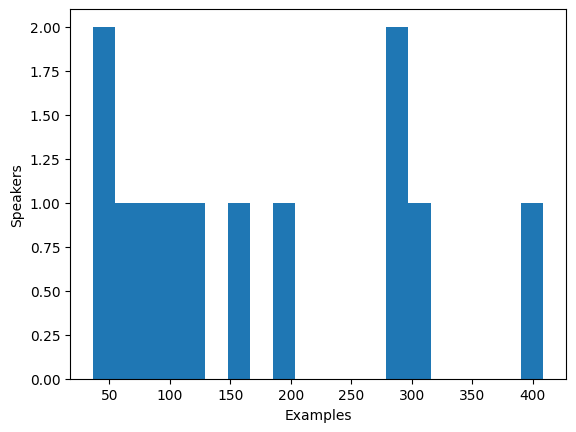

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()


In [ ]:
# Limiting the speakers with 100 and 400 examples.
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/2099 [00:00<?, ? examples/s]

In [ ]:
len(dataset)

1355

In [ ]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

# creating speaker embedding
# This model is trained on Eng so may not capture the unique voice characteristics of dutch speaker.
spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
/tmp/ipython-input-15-3154753012.py:3: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/hyperparams.yaml' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/hyperparams.yaml'
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
/usr/local/lib/python3.11/dist-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook fo

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/embedding_model.ckpt' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/mean_var_norm_emb.ckpt' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/classifier.ckpt' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/classifier.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /tmp/speechbrain/spkrec-xvect-voxceleb/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.fetching:Fetch: Local file found, creating symlink '/root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/label_encoder.txt' -> '/tmp/speechbrain/spkrec-xvect-voxceleb/label_encoder.ckpt'
DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /tmp/speechbrain/spkrec-xvect-voxceleb/label_encoder.ckpt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /tmp/speechbrain/spkrec-xvect-voxceleb/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /tmp/speechbrain/spkrec-xvect-voxceleb/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): classifier -> /tmp/speechbra

In [ ]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [ ]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [ ]:
processed_example["speaker_embeddings"].shape

(512,)

In [ ]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/1355 [00:00<?, ? examples/s]

In [ ]:
# Removing examples having longer than maximum input length
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter:   0%|          | 0/1355 [00:00<?, ? examples/s]

1039

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [ ]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

In [ ]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_sl",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=1000,
    gradient_checkpointing=True,
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=500,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=False,
)

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

/tmp/ipython-input-31-1231872571.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
500,0.504200,0.480423
1000,0.476900,0.465201


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.5428759603500366, metrics={'train_runtime': 2296.8271, 'train_samples_per_second': 13.932, 'train_steps_per_second': 0.435, 'total_flos': 4433997557327184.0, 'train_loss': 0.5428759603500366, 'epoch': 33.34188034188034})